# Barents Sea example

In this notebook we want to attempt a few things in the Barents Sea as an example:

- TS and volume distributions over 2014
- TS and volume distributinos over the 5-year period
- specific properties and their variation with T and S (T will be on x axis, heat flux sum on y-axis as an example, or summed advective flux on y-axis)
- label water masses or think about what can be seen in these TS diagrams

### Import packages, libraries, functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from ts2dte import ts2dte

### Read grid and masks

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [10]:
# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [11]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

In [12]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


### Get the timesteps we want

In [13]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600
startyr = 2002
endyr = 2019

days_reg = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
days_leap = np.array([31,29,31,30,31,30,31,31,30,31,30,31])
days_reg = days_reg*24*3600/dt
days_leap = days_leap*24*3600/dt

years = np.arange(startyr,endyr,1)

# make an array of all the filenames before cumsum
fnames = np.array([],dtype=int)

for year in years:
    if is_leap(year):
        fnames = np.append(fnames,days_leap)
    else:
        fnames = np.append(fnames,days_reg)
fnames = np.cumsum(fnames)

In [14]:
# now get this specific year, we want December 2014
# what if we want
months = np.arange(1,13,1)   # all the months of 2014, we also want the first month of 2015 so we can do tendency for 12/2014
year = 2014
tsstrs = np.array([])
datetimes = np.array([])     # make an array of datetime values to store
f_toread = np.array([],dtype=int)
for inf in fnames:
    thisfile = ts2dte(inf,deltat=600,startyr=2002,startmo=1,startdy=1)
    if thisfile.year == year and thisfile.month in months: 
        #print(thisfile)  # this would be used as the second time step for the month of November, not what we want
        datetimes = np.append(datetimes,thisfile)
        f_toread = np.append(f_toread,int(inf))

t_day = f_toread.astype(str)
tsstr = np.array([str(item).zfill(10) for item in t_day])

# we also want month 1 of 2015
months = 1
year = 2015
f_toread = np.array([],dtype=int)
for inf in fnames:
    thisfile = ts2dte(inf,deltat=600,startyr=2002,startmo=1,startdy=1)
    if thisfile.year == year and thisfile.month == months: 
        #print(thisfile)  # this would be used as the second time step for the month of November, not what we want
        datetimes = np.append(datetimes,thisfile)
        f_toread = np.append(f_toread,int(inf))

t_day = f_toread.astype(str)
t_day = np.array([str(item).zfill(10) for item in t_day])
tsstr = np.append(tsstr,t_day)

# print(tsstr)
# print(datetimes)

### Isolate the volumes from ETAN

In [15]:
# ocean and ice
AB_gT=0
debug = False

In [16]:
# ffac = 1e-6
ffac = 1

In [76]:
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    #t2 = tsstr[t+1]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])
    SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[2])

    # do differencing
    #dETAN_dt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt  # change naming to dEtan_dt  m/s
    #dSIheff_dt =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
    #dSIhsnow_dt = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

    # choose by basin
    # select by existing basin in mskBasin
    ETAN = np.reshape(ETAN,(ny,nx)) * wetmask[0,:,:]
    #dETAN_dt = np.reshape(dETAN_dt,(ny,nx)) * myMask
    #dSIheff_dt = np.reshape(dSIheff_dt,(ny,nx)) * myMask
    #dSIhsnow_dt = np.reshape(dSIhsnow_dt,(ny,nx)) * myMask

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        #tmpvol = tmp2 * mk3D_mod(RAC, hfC)                   # existing volume without ETAN
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3
        #tmpvol += dvol
        #print(np.nanmin(tmpvol))

    vol[t,:,:,:] = tmpvol

print(vol.shape)

volume allocation shape (13, 50, 1350, 270)
(13, 50, 1350, 270)


### Now we can read and bin thetadr and saltdr

In [77]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = binsTH[:,:,0].flatten()
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

binsSLT = rdmds(dirrun_small + "layers1SLT", -1)
binsSLT_edges = binsSLT[:,:,0].flatten()
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

In [78]:
# read in the initial model T-S fields
# create an array to store the values at all time steps
fileTS = np.zeros((len(tsstr),2,nz,ny,nx))
print(fileTS.shape)

# read each of the files from the list
for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = int(t1)

    # read the file
    thisfileTS = rdmds(dirIn + "budg3d_snap_set2",read)    # dr values, z, y, x
    thisfldListTS = parsemeta(dirIn + "budg3d_snap_set2." + tsstr[t] + ".meta")["fldList"]
    
    thisfileTS = thisfileTS.reshape(2,nz, ny, nx)

    fileTS[t,:,:,:,:] = thisfileTS

(13, 2, 50, 1350, 270)


In [79]:
# we should unweight these before we add them to the dataset
DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))
temp = fileTS[:,0,:,:,:] / DRF3d
salt = fileTS[:,1,:,:,:] / DRF3d

### Let's mask everything with mskBasin and wetmask just to be certain

In [80]:
vol *= wetmask[np.newaxis,:,:,:]
temp *= wetmask[np.newaxis,:,:,:]
salt *= wetmask[np.newaxis,:,:,:]

In [81]:
# set where not equal to basin to nan
bool_msk = mskBasin!= iB
vol[:,:,bool_msk] = np.nan
temp[:,:,bool_msk] = np.nan
salt[:,:,bool_msk] = np.nan   # shape time, dz, dy, dx

### Now write to dataset

In [82]:
dims = ("iteration","z","compact_x","compact_y")
coords = {"iteration" : datetimes,
          "z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsT = {'title' : 'wighted T data from budg3d_snap_set2 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'degree_c'}

attrsS = {'title' : 'weighted S data from budg3d_snap_set2 example from official ASTE',
         'standard_name' : 'salinity',
         'units' : 'ppt'}

attrsVol = {'title' : 'volume calculated from budg2d_snap_set1',
         'standard_name' : 'volume (m^3)',
         'units' : 'ppt'}

In [83]:
temp = xr.DataArray(data = temp,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

salt = xr.DataArray(data = salt,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

volume = xr.DataArray(data = vol,
                    dims = dims,
                    coords = coords,
                    attrs = attrsVol)

In [84]:
ds = xr.Dataset({'theta': temp, 'salinity': salt, 'volume':volume})
del salt, temp,vol

### Do the binning in TS - add to array

In [85]:
# let's create a binning function with numpy
def bin_array(arr, bin_edges):
    flattened_arr = arr.flatten()
    bin_indices = np.digitize(flattened_arr, bin_edges)
    bin_indices_3d = bin_indices.reshape(arr.shape)
    
    return bin_indices_3d-1

In [86]:
# create this as an xarray and add it to the dataset
# now the bins should go up to 112
binned_theta = bin_array(ds.theta.values,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
# print(np.nanmin(binned_theta),np.nanmin(ds.theta.values),binsTH_edges[int(np.nanmin(binned_theta))])
binned_salinity = bin_array(ds.salinity.values,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan
# print(np.nanmin(binned_salinity),np.nanmin(ds.salinity.values),binsSLT_edges[int(np.nanmin(binned_salinity))])

binned_temp = xr.DataArray(data = binned_theta*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

binned_salt = xr.DataArray(data = binned_salinity*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [87]:
ds["theta_binned"] = binned_temp
ds["salinity_binned"] = binned_salt

del binned_temp,binned_salt

In [88]:
del binned_theta, binned_salinity

In [89]:
binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [90]:
# lets make this into a loop if we can difference in time, we can divide by dT and dS at the end

testmesh = np.zeros((len(ds.iteration.values),nS, nT, npoints))     #ntimes x nS x nT x points in basin
nT = binsTH_edges.shape[0]-1
nS = binsSLT_edges.shape[0]-1

tn = 0
for t in ds.iteration.values:
    print(tn)
    dsx = ds.sel(iteration = t)

    # select the values at this iteration number
    thisvol = dsx.volume.values[:,mskBasin == iB]
    thissalt = dsx.salinity_binned.values[:,mskBasin == iB]
    thistemp = dsx.theta_binned.values[:,mskBasin == iB]

    # trim the fat (nan values)
    thisvol = np.where(np.isnan(thisvol), 0, thisvol)
    thissalt = np.where(np.isnan(thissalt), -1, thissalt)  # Replace NaN with -1
    thistemp = np.where(np.isnan(thistemp), -1, thistemp)  # as above, indexing should not matter because this should be 0 volume

    #print(thisvol.shape,thissalt.shape,thistemp.shape)

    # get m^3/deg C/PSU
    val = thisvol.copy()

    # create the mesh
    meshx = np.zeros((nS, nT, npoints))

    saltflat = thissalt.flatten()
    tempflat = thistemp.flatten()

    # create local timed mesh
    np.add.at(meshx, (thissalt.astype(int), thistemp.astype(int), np.arange(0,npoints,1)), thisvol[...])  # this should work to add at bins
    meshx /= dT   # m^3/deg C
    meshx /= dS   # m^3/deg C/PSU

    # add to big mesh
    testmesh[tn,:,:,:] = meshx

    # delete for memory
    del meshx
    
    tn += 1

0
1
2
3
4
5
6
7
8
9
10
11
12


### Add the testmesh to the dataset, also tendency

In [91]:
testmesh.shape

(13, 112, 112, 10650)

In [92]:
# add the mesh to the dataset
attrsmesh = {'title' : 'mesh for basin with volumes at each T and S bin',
         'standard_name' : 'volume mesh',
         'units' : 'm^3/deg C/PSU'}
dims = ("iteration","i_Tbins","i_Sbins","points")
# not sure if we want the bin centers I think so 
coords = {"iteration" : datetimes,
          "i_Tbins" : np.arange(0,nT,1),
          "i_Sbins" : np.arange(0,nS,1),
          "points" : np.arange(0,npoints,1)}

In [93]:
# syntax
mesh = xr.DataArray(data = testmesh,
                    dims = dims,
                    coords = coords,
                    attrs = attrsmesh)
ds["mesh"] = mesh

In [94]:
del mesh

### Plotting for snap volumes

In [95]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = mpl.cm.get_cmap("viridis").copy()
cmap.set_under(color='white')

/tmp/ipykernel_2689953/1350057631.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis").copy()


In [142]:
Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

In [97]:
# # let's just plot 4 time steps as an example of volume/TS scatter

# num_plots = 6 #ds.iteration.values.shape[0]
# rows = 3
# cols = 2
# fig,axes = plt.subplots(rows,cols,sharex=True, sharey=True,figsize=(8,20))
# if num_plots>1:
#     axes = axes.flatten()

# tn = 0
# for i in range(num_plots):
#     ax = axes[i]

#     if i%2 == 0:
#         # get new ds and plot from mesh
#         dsx = ds.sel(iteration = ds.iteration.values[tn])
#         testmesh = dsx.mesh.values
#         title = ds.iteration.values[i]
#         testmesh[testmesh == 0 ] = np.nan     # might want to add this into the previous calc loop
#         testmesh = np.nansum(testmesh,axis=2)
        
#         # plot
#         pc = ax.pcolormesh(Sbin,Tbin,np.log10(testmesh), cmap=cmap,vmin=0.001)
#         fig.colorbar(pc)
#         ax.set_title(title)
#         ax.set_xlabel("S")
#         ax.set_ylabel("T")
#         ax.set_xlim(10,36)
#         ax.set_ylim(-3,10)
#         ax.grid()
#         tn += 1

#     else:
#         # plot TS scatter
#         s = dsx.salinity.values.flatten()
#         t = dsx.theta.values.flatten()
        
#         pc = ax.scatter(s,t,s=0.1)
#         fig.colorbar(pc)
#         ax.set_title(title)
#         ax.set_xlabel("S")
#         ax.set_ylabel("T")
#         ax.set_xlim(10,36)
#         ax.set_ylim(-3,10)
#         ax.grid()

### Calculate tendency for time steps

2678400


(-2.5, 10.0)

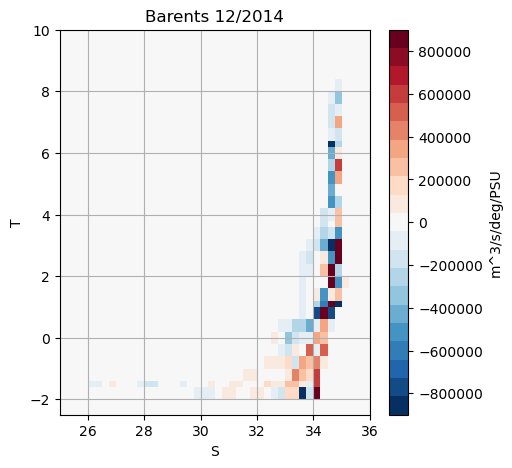

In [105]:
# the tendency will be the difference between each of the time steps
# test for December - will be difference of last two time steps in ds

# this is wrong
dec_tend = ds.mesh.values[-1,:,:,:] - ds.mesh.values[-2,:,:,:] # m^3/psu/degC/month
dt = (ds.iteration[-1].values - ds.iteration[-2].values) * 1e-9   # seconds
print(int(dt))
dec_tend/=int(dt)    # # m^3/s/psu/degC
dec_tend = np.nansum(dec_tend/1e1,axis=2)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

# add volume distribution
title = "Barents 12/2014"

# norm = TwoSlopeNorm(vmin=-1e6, vcenter=0, vmax=1e6)
# norm = TwoSlopeNorm(vmin=np.nanmin(dec_tend), vcenter=0, vmax=np.nanmax(dec_tend))
cmap = plt.get_cmap('RdBu_r',21).copy()
norm = TwoSlopeNorm(vmin=-9e5, vcenter=0, vmax=9e5)
cb = plt.pcolormesh(Sbin,Tbin,dec_tend, norm=norm, cmap=cmap,label="tend (log(m^3)/deg/PSU)")

# labels
fig.colorbar(cb,label = "m^3/s/deg/PSU")
ax.set_title(title)
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)

### Try to plot for all of 2014

In [100]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/"
((ds.iteration[i+1].values - ds.iteration[i].values))

numpy.timedelta64(2678400000000000,'ns')

In [141]:
num_plots = ds.iteration.values.shape[0]-1  # 12 months
rows = 3
cols = 4
fig,axes = plt.subplots(rows,cols,sharex=True, sharey=True,figsize=(20,16))
if num_plots>1:
    axes = axes.flatten()

for i in range(num_plots):
    print(i)
    ax = axes[i]

    # get the volume of t2 - t1
    v2 = np.nansum(ds.mesh.values[i+1,:,:,:],axis=2)
    v1 = np.nansum(ds.mesh.values[i,:,:,:],axis=2)
    timedelta = ds.iteration[i+1].values - ds.iteration[i].values
    dt = timedelta.astype('timedelta64[s]').astype(np.int32)

    thistend = (v2-v1)/dt    # d m^3 / s
    # add volume distribution
    title = str(ds.iteration.values[i])[:7]
    
    #norm = TwoSlopeNorm(vmin=np.nanmin(thistend), vcenter=0, vmax=np.nanmax(thistend))
    norm = TwoSlopeNorm(vmin=np.nanmin(thistend)/5,vcenter=0,vmax=np.nanmax(thistend)/5)
    cb = ax.pcolormesh(Sbin,Tbin,thistend, norm=norm, cmap=cmap)
    
    # labels
    fig.colorbar(cb,label="m^3/s/deg/PSU")
    ax.set_title(title)
    ax.set_xlabel("S")
    ax.set_ylabel("T")
    ax.grid()
    ax.set_xlim(25,36)
    ax.set_ylim(-2.5,10)

# plt.savefig(path + "Barents_tend_2014_v4.png",dpi = 300)

0
(112, 112) (113, 113)
1
(112, 112) (113, 113)
2


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x148daab769d0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x148d4f974670> (for post_execute):


KeyboardInterrupt: 

### Try to plot with oceQnet

Deleted code here to create the mesh because it was wrong. See above

In [ ]:
# # add the rho lines
# # add the polygons and the points
# smin = 26 - (0.01 * 26)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
# smax = 36. + (0.01 * 36.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
# tmin = -2.5 + (0.1 * -2.5)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
# tmax = 7.5 + (0.1 * 7.5)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
# print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# # Calculate how many gridcells we need in the x and y dimensions
# xdim = 30
# ydim = 30
# # Create empty grid of zeros
# dens = np.zeros((ydim,xdim))
# # Create temp and salt vectors of appropiate dimensions
# ti = np.linspace(-2.5,7.5,ydim)
# si = np.linspace(26,36,xdim)
# Freez_temp = gsw.CT_freezing(si,0,0)

# Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# # Loop to fill in grid with densities
# for j in range(0,int(ydim)):
#     for i in range(0, int(xdim)):
#         #print(si[i],ti[j])
#         dens[j,i]=gsw.rho(si[i],ti[j],0)
#         # Substract 1000 to convert to sigma-0
# dens2 = dens - 1000

# # convert to practical/potential - ask An if we need to do this? What model output?
# # long = 73.5089
# # lat = -66.8245
# # ti = gsw.pt_from_CT(si1,ti1)
# # si = gsw.SP_from_SA(si1,0,long,lat)

### Plot distribution with OceQnet/try vertical convergence

In [110]:
tsstr

array(['0000631152', '0000635616', '0000639648', '0000644112',
       '0000648432', '0000652896', '0000657216', '0000661680',
       '0000666144', '0000670464', '0000674928', '0000679248',
       '0000683712'], dtype='<U10')

In [118]:
file_name = 'budg2d_zflux_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(["oceQsw"])             # W/m^2, net surface heat flux into the ocean (+=down), >0 increases theta
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
q = np.zeros((len(tsstr), ny, nx))
print("volume allocation shape",q.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    #t2 = tsstr[t+1]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    # select by existing basin in mskBasin
    oceQsw = np.reshape(oceQsw,(ny,nx)) * wetmask[0,:,:] * mymsk

    # we want to isolate oceQsw by multiplying by RAC (the surface)
    tmpq = RAC * oceQsw      # m^2 * W/m^2 = W

    # add this time step to the mesh
    q[t,:,:] = tmpq     # W

print(q.shape)

volume allocation shape (13, 1350, 270)
(13, 1350, 270)


0
1
2
3
4
5
6
7
8
9
10
11


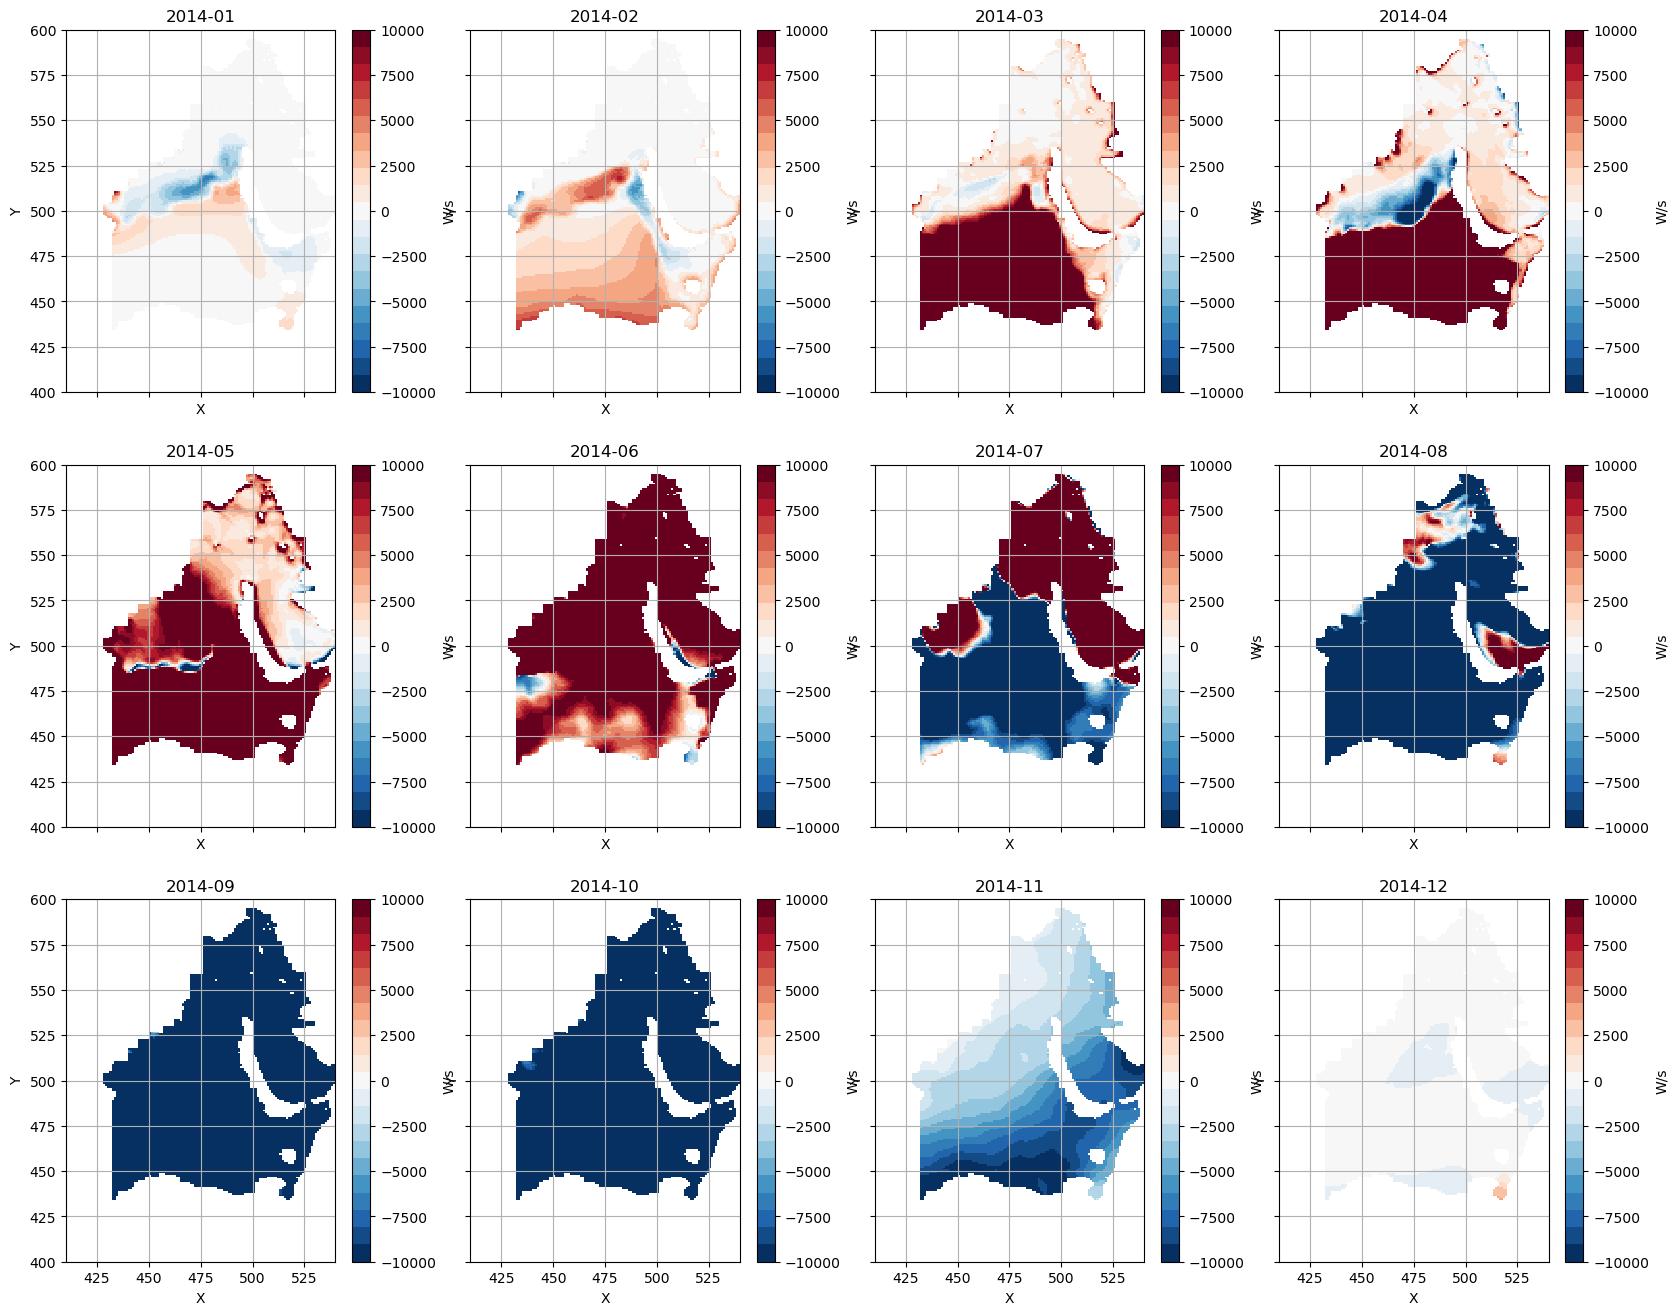

In [122]:
# get the difference in time of q to plot in x/y space
num_plots = ds.iteration.values.shape[0]-1  # 12 months
rows = 3
cols = 4
fig,axes = plt.subplots(rows,cols,sharex=True, sharey=True,figsize=(20,16))
if num_plots>1:
    axes = axes.flatten()

for i in range(num_plots):
    print(i)
    ax = axes[i]

    timedelta = ds.iteration[i+1].values - ds.iteration[i].values
    dt = timedelta.astype('timedelta64[s]').astype(np.int32)

    title = str(ds.iteration.values[i])[:7]

    # get the difference over one month
    myq = (q[i+1,:,:]-q[i,:,:])/dt    # W / s
    
    norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
    cb = ax.pcolormesh(get_aste_tracer(myq,nfx,nfy)[0],norm=norm,cmap=cmap)
    
    # labels
    fig.colorbar(cb,label="W/s")
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid()
    ax.set_xlim(410,540)
    ax.set_ylim(400,600)
# plt.savefig(path + "Barents_tend_2014_v4.png",dpi = 300)

In [126]:
# try to make a mesh for these values in TS space
# lets make this into a loop if we can difference in time, we can divide by dT and dS at the end

testmesh = np.zeros((len(ds.iteration.values),nS, nT, npoints))     #ntimes x nS x nT x points in basin
nT = binsTH_edges.shape[0]-1
nS = binsSLT_edges.shape[0]-1

tn = 0
for t in ds.iteration.values:
    print(tn)
    dsx = ds.sel(iteration = t)

    # select the values at this iteration number
    thisq = q[tn,mskBasin == iB]       # these should just be at the surface
    thissalt = dsx.salinity_binned.values[0,mskBasin == iB]       # these should just be at the surface
    thistemp = dsx.theta_binned.values[0,mskBasin == iB ]       # these should just be at the surface

    # trim the fat (nan values)
    thisq = np.where(np.isnan(thisq), 0, thisq)
    thissalt = np.where(np.isnan(thissalt), -1, thissalt)  # Replace NaN with -1
    thistemp = np.where(np.isnan(thistemp), -1, thistemp)  # as above, indexing should not matter because this should be 0 volume

    #print(thisvol.shape,thissalt.shape,thistemp.shape)

    # get m^3/deg C/PSU
    val = thisq.copy()

    # create the mesh
    meshx = np.zeros((nS, nT, npoints))

    saltflat = thissalt.flatten()
    tempflat = thistemp.flatten()
    qflat = thisq.flatten()

    # create local timed mesh
    np.add.at(meshx, (thissalt.astype(int), thistemp.astype(int), np.arange(0,npoints,1)), thisq[...])  # this should work to add at bins
    meshx /= dT   # m^3/deg C
    meshx /= dS   # m^3/deg C/PSU

    # add to big mesh
    testmesh[tn,:,:,:] = meshx

    # delete for memory
    del meshx
    
    tn += 1

0
1
2
3
4
5
6
7
8
9
10
11
12


In [129]:
testmesh.shape

(13, 112, 112, 10650)

In [136]:
thistend.shape

(1350, 270)

0
1
2
3
4
5
6
7
8
9
10
11


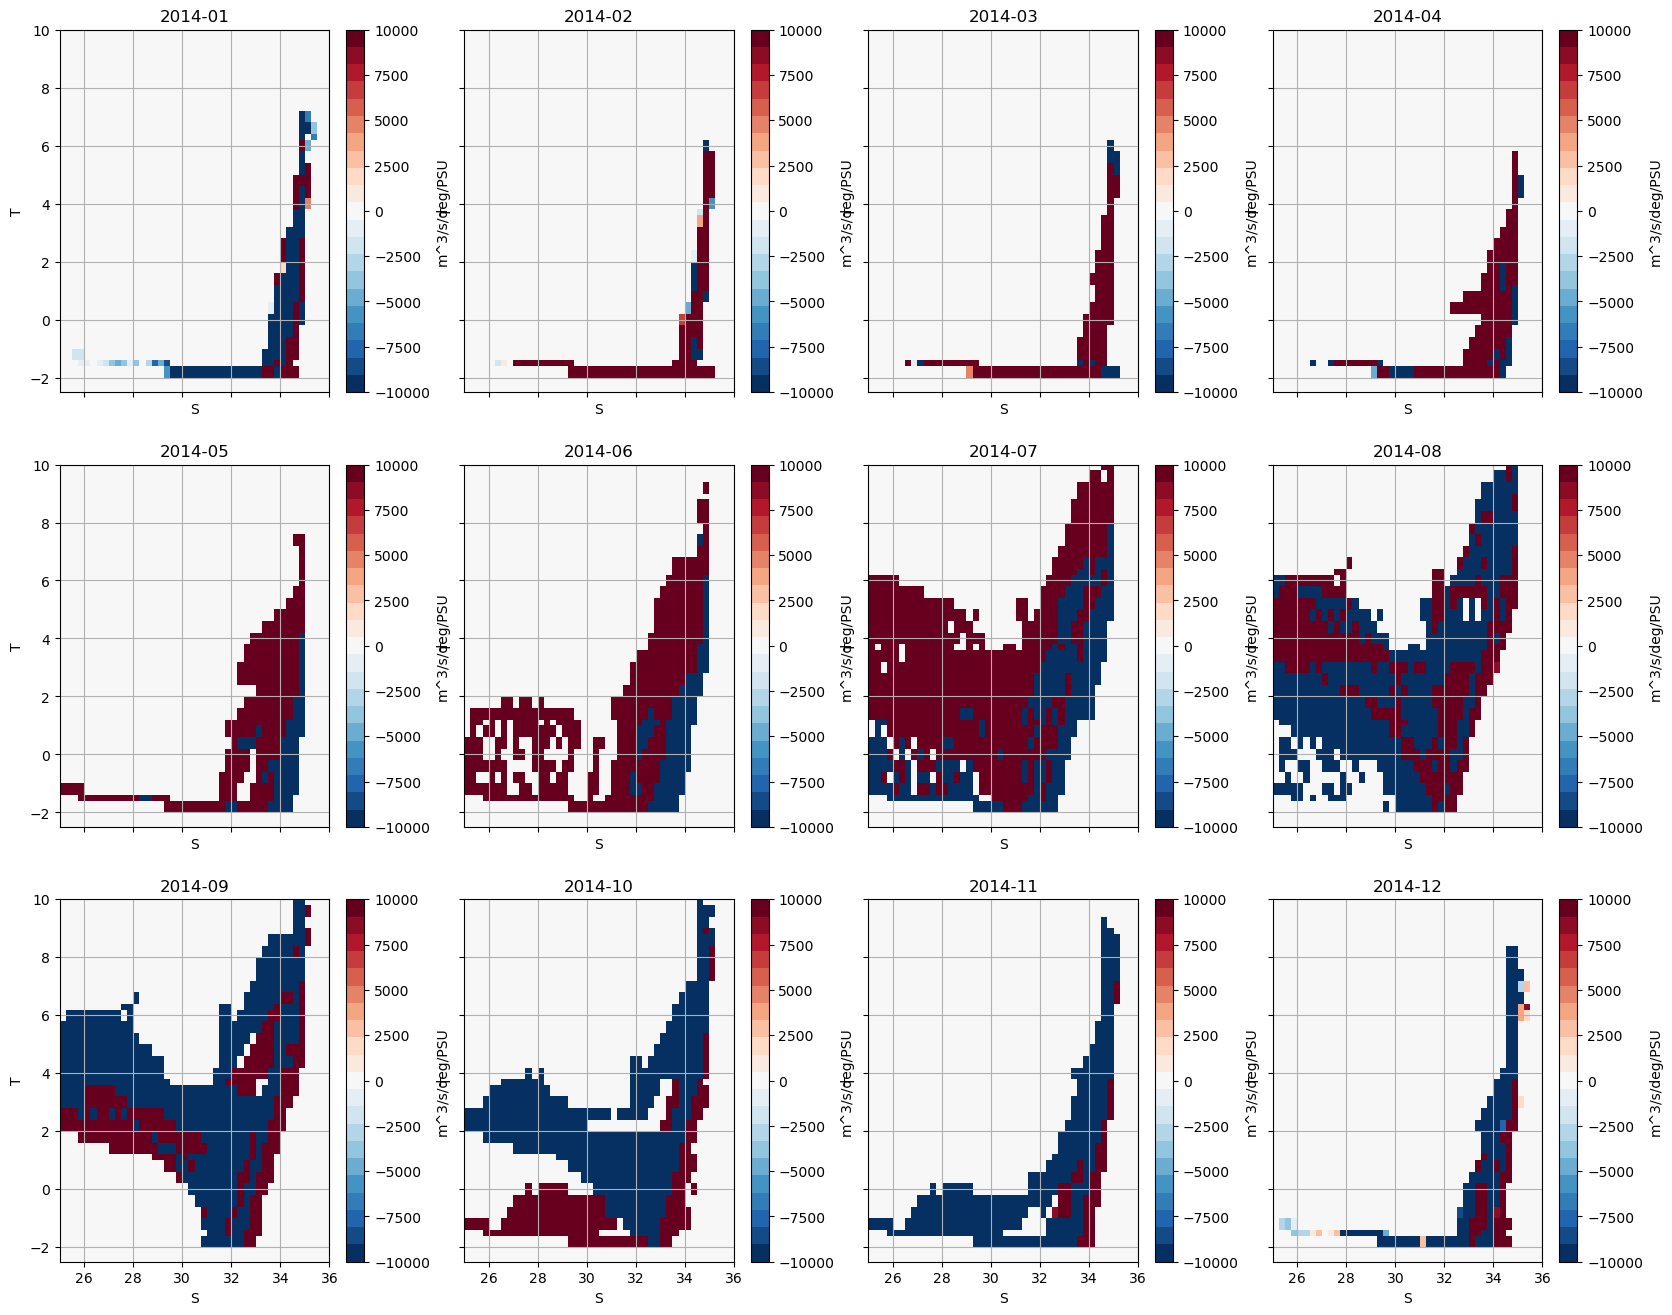

In [143]:
num_plots = ds.iteration.values.shape[0]-1  # 12 months
rows = 3
cols = 4
fig,axes = plt.subplots(rows,cols,sharex=True, sharey=True,figsize=(20,16))
if num_plots>1:
    axes = axes.flatten()

for i in range(num_plots):
    print(i)
    ax = axes[i]

    # get the volume of t2 - t1
    dq = np.nansum(testmesh[i+1,:,:,:],axis=2) - np.nansum(testmesh[i,:,:,:],axis=2)
    timedelta = ds.iteration[i+1].values - ds.iteration[i].values
    dt = timedelta.astype('timedelta64[s]').astype(np.int32)

    thistend = dq/dt    # d W / s
    
    title = str(ds.iteration.values[i])[:7]
    
    #norm = TwoSlopeNorm(vmin=np.nanmin(thistend), vcenter=0, vmax=np.nanmax(thistend))
    norm = TwoSlopeNorm(vmin=-1e6,vcenter=0,vmax=1e6)
    cb = ax.pcolormesh(Sbin,Tbin,thistend, norm=norm, cmap=cmap)
    
    # labels
    fig.colorbar(cb,label="m^3/s/deg/PSU")
    ax.set_title(title)
    ax.set_xlabel("S")
    ax.set_ylabel("T")
    ax.grid()
    ax.set_xlim(25,36)
    ax.set_ylim(-2.5,10)

# plt.savefig(path + "Barents_tend_2014_v4.png",dpi = 300)